<a href="https://colab.research.google.com/github/Kneppled/algorithms/blob/main/GANs_Research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Dataset


In [1]:
import os
os.environ['KAGGLE_USERNAME'] = "remixie" # username from the file
os.environ['KAGGLE_KEY'] = "401fbb3a04929a68e215031e994896e1" # key from the file
!kaggle datasets download -d emstatsl/csgo-cheating-dataset # api copied from kaggle

Dataset URL: https://www.kaggle.com/datasets/emstatsl/csgo-cheating-dataset
License(s): unknown
 99% 455M/461M [00:00<00:00, 1.62GB/s]
100% 461M/461M [00:00<00:00, 1.59GB/s]


In [2]:
from zipfile import ZipFile
zf = ZipFile('csgo-cheating-dataset.zip')
#extracted data is saved in the same directory as notebook
zf.extractall()
zf.close()

In [3]:
import numpy as np
legit_data = np.load('legit/legit.npy')
# Read the NPY file
cheater_data = np.load('cheaters/cheaters.npy')

# Normalize Data


In [4]:
l_max = np.max(legit_data, axis=(0,1,2))
l_min = np.min(legit_data, axis=(0,1,2))

c_max = np.max(cheater_data, axis=(0,1,2))
c_min = np.min(cheater_data, axis=(0,1,2))

max_val = [ max(l_max[i], c_max[i]) for i in range(len(c_max)) ]
min_val = [ min(l_min[i], c_min[i]) for i in range(len(c_min)) ]

norm_legit_data = legit_data.copy()
norm_cheater_data = cheater_data.copy()

In [5]:
import copy
import numpy as np


# GAN = 1 True, 1 Generator data
# ourGAN = 1 cheater, 1 legit... where does Generator come in? How does it 'fool' the discrimator
print('AttackerDeltaYaw, AttackerDeltaPitch, CrosshairToVictimYaw, CrosshairToVictimPitch, Firing')
print("ranges legit:\nMax ", max_val, '\nMin ', min_val)

norm_legit_data = copy.deepcopy(legit_data)
norm_cheater_data = copy.deepcopy(cheater_data)
print('data copied')

# Flatten the datasets together to compute global min/max
all_data = np.concatenate([legit_data, cheater_data], axis=0)
min_val = np.min(all_data, axis=(0,1,2))
max_val = np.max(all_data, axis=(0,1,2))

for dataset in [norm_legit_data, norm_cheater_data]:
  for playerrecording in dataset:
    for entry in playerrecording:
      for frame in entry:
        for id in (0,1,2,3):
          # should translate to: xnorm = (x - xmin) / (xmax - xmin)
          frame[id] = -1 + 2* ((frame[id] - min_val[id]) / (max_val[id] - min_val[id]))


#due to not being the full 10,000 entries, it's not a perfect -1:1 scale
print("Maximium in dataset:", np.max(norm_legit_data[:200], axis=(0,1,2)))
print("Minimium in dataset:", np.min(norm_legit_data[:200], axis=(0,1,2)))

#due to not being the full 2,000 entries, it's not a perfect -1:1 scale
print("Maximium in dataset:", np.max(norm_cheater_data[:200], axis=(0,1,2)))
print("Minimium in dataset:", np.min(norm_cheater_data[:200], axis=(0,1,2)))

AttackerDeltaYaw, AttackerDeltaPitch, CrosshairToVictimYaw, CrosshairToVictimPitch, Firing
ranges legit:
Max  [np.float32(179.863), np.float32(96.938), np.float32(180.0), np.float32(119.461), np.float32(1.0)] 
Min  [np.float32(-180.0), np.float32(-98.602), np.float32(-180.0), np.float32(-154.133), np.float32(0.0)]
data copied
Maximium in dataset: [0.987723   0.2448808  0.9999722  0.77650094 1.        ]
Minimium in dataset: [-0.9793644 -0.3565818 -0.9999944 -0.762853   0.       ]
Maximium in dataset: [0.90947664 0.94639444 0.9998888  0.8080075  1.        ]
Minimium in dataset: [-0.98605025 -0.932689   -0.9999833  -0.5922718   0.        ]


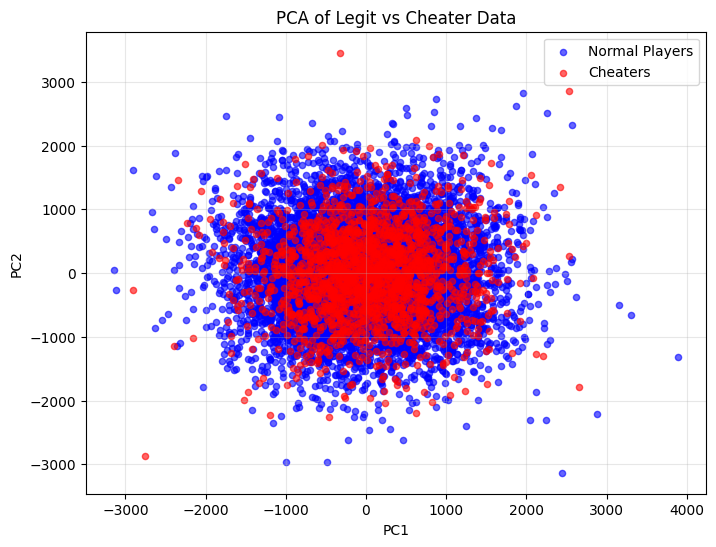

In [6]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load your data (already done)
# legit_data = np.load('legit/legit.npy')
# cheater_data = np.load('cheaters/cheaters.npy')

# Flatten each player/session into a single vector
X_legit_flat = legit_data.reshape(legit_data.shape[0], -1)
X_cheat_flat = cheater_data.reshape(cheater_data.shape[0], -1)

# Combine data
X_all = np.concatenate([X_legit_flat, X_cheat_flat], axis=0)
y_all = np.concatenate([
    np.zeros(len(X_legit_flat)),  # normal players = 0
    np.ones(len(X_cheat_flat))    # cheaters = 1
], axis=0)

# PCA to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_all)

# Scatter plot
plt.figure(figsize=(8,6))
plt.scatter(X_pca[y_all==0,0], X_pca[y_all==0,1], c='blue', label='Normal Players', alpha=0.6, s=20)
plt.scatter(X_pca[y_all==1,0], X_pca[y_all==1,1], c='red', label='Cheaters', alpha=0.6, s=20)
plt.title('PCA of Legit vs Cheater Data')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

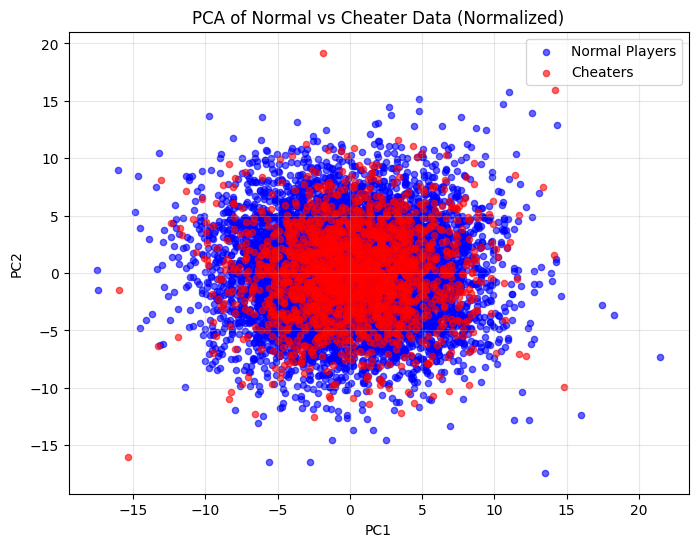

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Flatten normalized data
X_legit_flat = norm_legit_data.reshape(norm_legit_data.shape[0], -1)
X_cheat_flat = norm_cheater_data.reshape(norm_cheater_data.shape[0], -1)

# Combine data
X_all = np.concatenate([X_legit_flat, X_cheat_flat], axis=0)
y_all = np.concatenate([
    np.zeros(len(X_legit_flat)),  # normal players = 0
    np.ones(len(X_cheat_flat))    # cheaters = 1
], axis=0)

# PCA to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_all)

# Scatter plot
plt.figure(figsize=(8,6))
plt.scatter(X_pca[y_all==0,0], X_pca[y_all==0,1], c='blue', label='Normal Players', alpha=0.6, s=20)
plt.scatter(X_pca[y_all==1,0], X_pca[y_all==1,1], c='red', label='Cheaters', alpha=0.6, s=20)
plt.title('PCA of Normal vs Cheater Data (Normalized)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Data Preparation

In [8]:
import torch
#torch will be what we're using to make and work our GAN

#datatype misalignment, need to get it torch frendly
X_real = torch.tensor(norm_legit_data, dtype=torch.float32)
print(X_real.shape)
# X_real: tensor of shape (person count, entries per person, frames per entry, variables tracked per frame)


torch.Size([10000, 30, 192, 5])


In [9]:
import torch
#torch will be what we're using to make and work our GAN

#datatype misalignment, need to get it torch frendly
X_cheat = torch.tensor(norm_cheater_data, dtype=torch.float32)
print(X_cheat.shape)
# X_real: tensor of shape (person count, entries per person, frames per entry, variables tracked per frame)

torch.Size([2000, 30, 192, 5])


# Defining GAN classes & functions

In [10]:
import torch.nn as nn # Neural Network function package
class Generator(nn.Module):
    def __init__(self, noise_dim, hidden_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(noise_dim, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, output_dim),)
    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid())
    def forward(self, x):
        # Flatten the input tensor for the linear layer
        x = x.view(x.size(0), -1)
        return self.net(x)

class CheaterClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Cheater Data

In [11]:
# @title
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# create DataLoader
dataset = TensorDataset(X_cheat)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

noise_dim = 16
# size of noise vector for generator

# Ensure feature_dim is correctly set before instantiating models
feature_dim = X_cheat.shape[1] * X_cheat.shape[2] * X_cheat.shape[3]
print(f"Instantiating G and D with feature_dim: {feature_dim}")

# actually instantiate:
G = Generator(noise_dim=noise_dim, hidden_dim=64, output_dim=feature_dim)
D = Discriminator(input_dim=feature_dim, hidden_dim=64)

criterion = nn.BCELoss()
lr = 1e-4
optim_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
optim_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

Instantiating G and D with feature_dim: 28800


In [12]:
import torch

print(torch.__version__)
print(torch.version.cuda)  # CUDA version PyTorch was built for

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
G.to(device)
D.to(device)

if torch.cuda.is_available():
    print("CUDA GPU detected!")
    print("Device count:", torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No CUDA GPU detected.")

print(torch.cuda.is_available())

2.8.0+cu126
12.6
Using device: cuda
CUDA GPU detected!
Device count: 1
GPU 0: Tesla T4
True


Epoch 0/1000 | D_loss: 0.1001 | G_loss: 3.1145


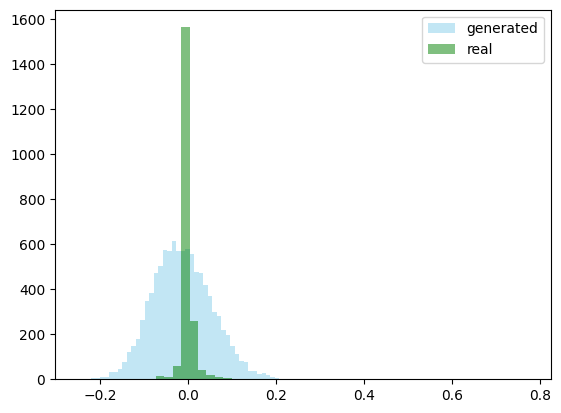

Epoch 100/1000 | D_loss: 0.2434 | G_loss: 2.8475


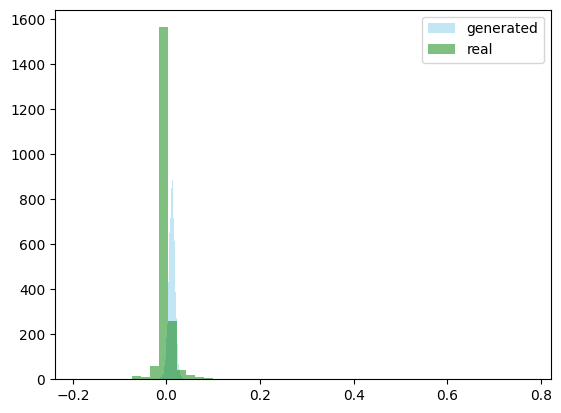

Epoch 200/1000 | D_loss: 0.6930 | G_loss: 0.7532


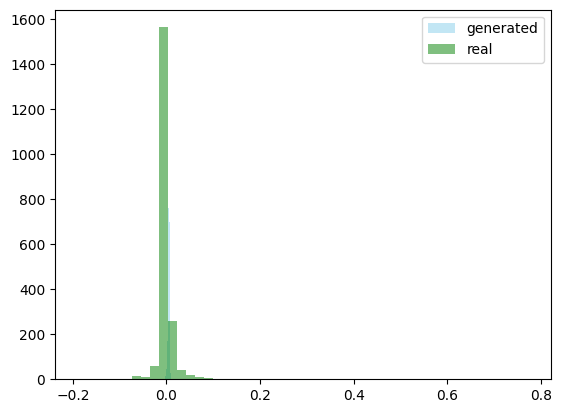

Epoch 300/1000 | D_loss: 0.1281 | G_loss: 3.5279


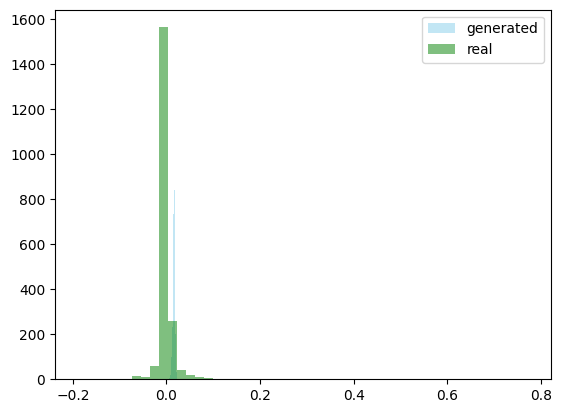

Epoch 400/1000 | D_loss: 0.0140 | G_loss: 4.8961


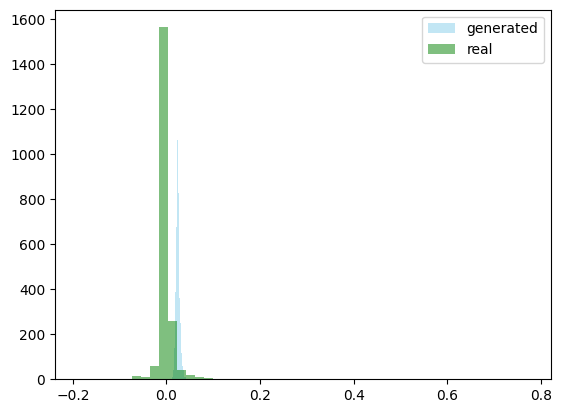

Epoch 500/1000 | D_loss: 0.0350 | G_loss: 6.4034


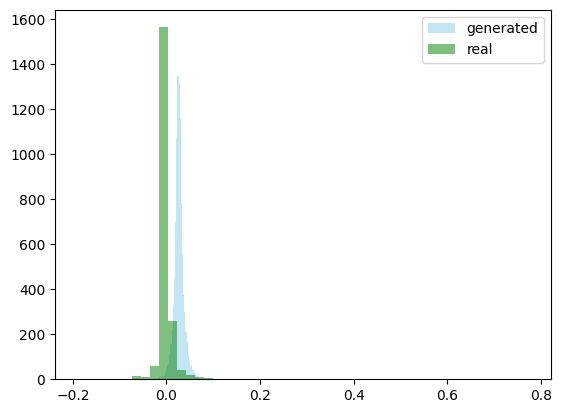

Epoch 600/1000 | D_loss: 0.0255 | G_loss: 4.5399


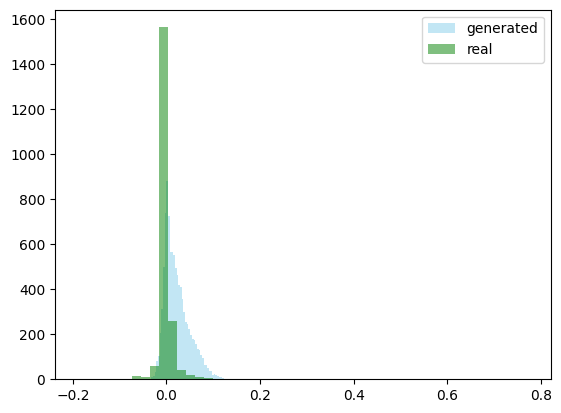

Epoch 700/1000 | D_loss: 0.1125 | G_loss: 4.7013


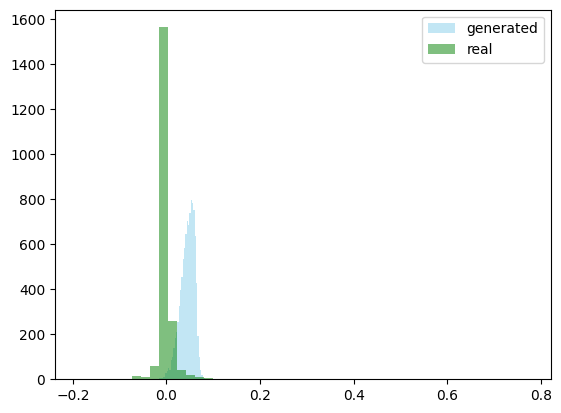

Epoch 800/1000 | D_loss: 0.0757 | G_loss: 4.0269


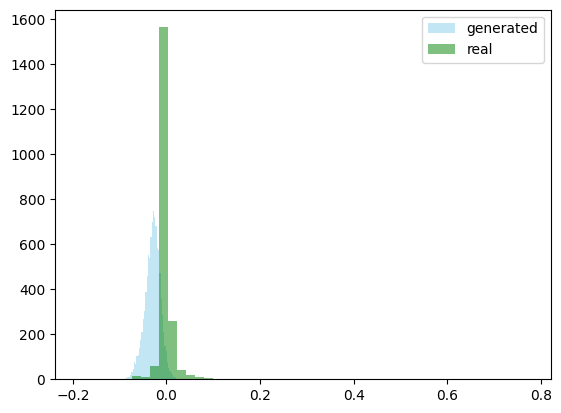

Epoch 900/1000 | D_loss: 0.0866 | G_loss: 5.2588


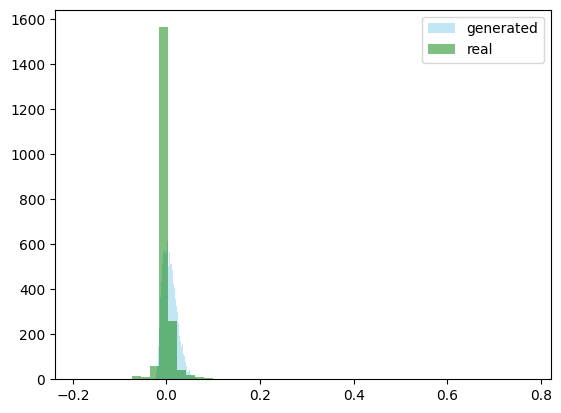

Epoch 1000/1000 | D_loss: 0.1204 | G_loss: 4.2034


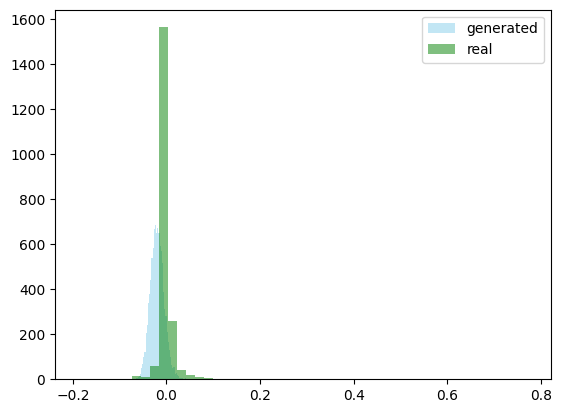

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

num_epochs = 1000
plot_every = 100  # epochs

real_samples_flat = X_cheat.reshape(len(X_cheat), -1)

for epoch in range(num_epochs + 1):
    for real_batch, in dataloader:
        real_batch = real_batch.to(device)
        batch_size = real_batch.size(0)


        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        # Train Discriminator
        D_real = D(real_batch)
        loss_real = criterion(D_real, real_labels)
        z = torch.randn(batch_size, noise_dim, device=device)
        fake_data = G(z).detach()
        D_fake = D(fake_data)
        loss_fake = criterion(D_fake, fake_labels)

        D_loss = (loss_real + loss_fake) / 2
        optim_D.zero_grad()
        D_loss.backward()
        optim_D.step()

        # Train Generator
        z = torch.randn(batch_size, noise_dim, device=device)
        fake_data = G(z)
        D_fake2 = D(fake_data)
        G_loss = criterion(D_fake2, real_labels)

        optim_G.zero_grad()
        G_loss.backward()
        optim_G.step()

    if epoch % plot_every == 0:
        print(f"Epoch {epoch}/{num_epochs} | D_loss: {D_loss.item():.4f} | G_loss: {G_loss.item():.4f}")

        z = torch.randn(10000, noise_dim, device=device)
        gen_samples = G(z).detach().cpu()
        plt.hist(gen_samples[:,0], color='skyblue', bins=50, alpha=0.5, label="generated")
        plt.hist(real_samples_flat[:,0], color='green', bins=50, alpha=0.5, label="real")
        plt.legend()
        plt.show()

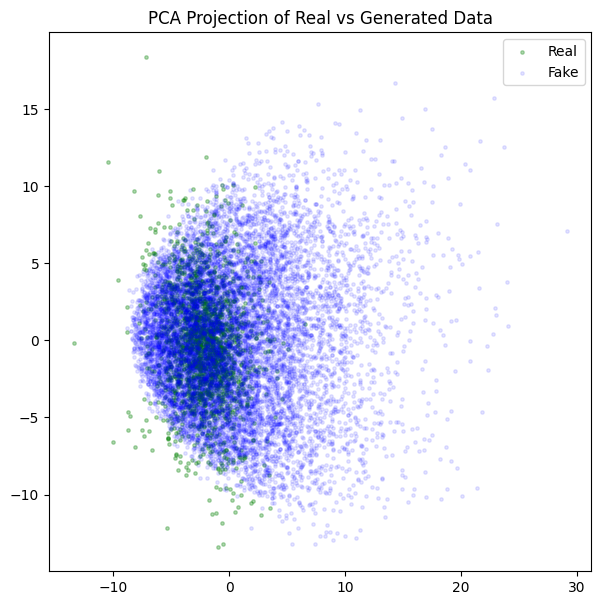

In [21]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch
import numpy as np

# Convert real + generated samples to flat arrays
real_flat = real_samples_flat.cpu().numpy()
fake_flat = gen_samples.cpu().numpy()

# Reduce to 2D using PCA
pca = PCA(n_components=2)
pca.fit(np.vstack([real_flat, fake_flat]))

real_2d = pca.transform(real_flat)
fake_2d = pca.transform(fake_flat)

# Scatter plot with transparency
plt.figure(figsize=(7, 7))
plt.scatter(real_2d[:, 0], real_2d[:, 1],
            alpha=0.30, s=6, c='green', label="Real")
plt.scatter(fake_2d[:, 0], fake_2d[:, 1],
            alpha=0.10, s=6, c='blue', label="Fake")

plt.title("PCA Projection of Real vs Generated Data")
plt.legend()
plt.show()

# Real Data Model

In [22]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch

# 1️⃣ Flatten real cheater + real non-cheater data ONLY
X_cheat_flat = X_cheat.view(X_cheat.shape[0], -1)
X_real_flat  = X_real.view(X_real.shape[0], -1)

# 2️⃣ Assign labels
y_cheat = torch.ones(len(X_cheat_flat), 1)      # cheaters = 1
y_real  = torch.zeros(len(X_real_flat), 1)      # normal = 0

# ❗ 3️⃣ Combine ONLY real data (GAN REMOVED)
X_all = torch.cat([X_real_flat, X_cheat_flat], dim=0)
y_all = torch.cat([y_real, y_cheat], dim=0)

# 4️⃣ Shuffle
perm = torch.randperm(X_all.shape[0])
X_all = X_all[perm]
y_all = y_all[perm]

# 5️⃣ Train-test split (no GAN)
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, stratify=y_all
)

# 6️⃣ Create datasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset  = TensorDataset(X_test, y_test)

# 7️⃣ Loaders (unchanged)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False)

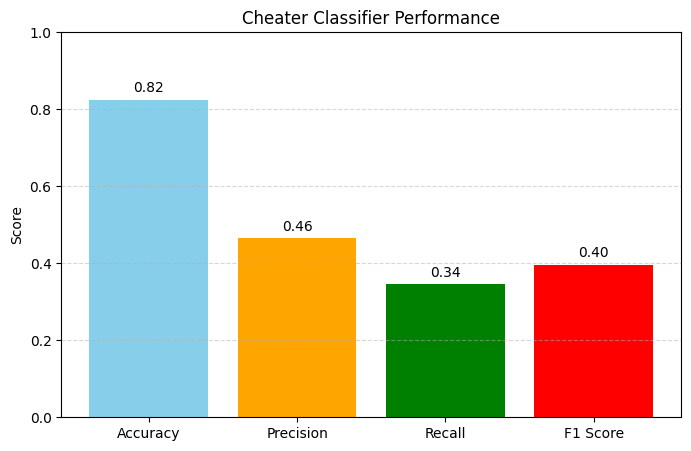

Accuracy : 0.8245833333333333
Precision: 0.46464646464646464
Recall   : 0.345
F1 Score : 0.39598278335724535


In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
import torch.nn as nn

# Define classifier
classifier = CheaterClassifier(input_dim=X_train.shape[1])
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

# Train classifier
num_epochs = 10
classifier.train()

for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = classifier(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

# Evaluate classifier
classifier.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = classifier(X_batch)
        preds = (outputs > 0.5).int()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Compute metrics
acc  = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds)
rec  = recall_score(all_labels, all_preds)
f1   = f1_score(all_labels, all_preds)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values  = [acc, prec, rec, f1]

# Plot metrics
plt.figure(figsize=(8,5))
plt.bar(metrics, values, color=['skyblue', 'orange', 'green', 'red'])
plt.ylim(0,1)
plt.ylabel("Score")
plt.title("Cheater Classifier Performance")
for i, v in enumerate(values):
    plt.text(i, v+0.02, f"{v:.2f}", ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# Print metrics
print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1 Score :", f1)

# GAN generated model

In [24]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch

# Flatten all data
X_cheat_flat = X_cheat.view(X_cheat.shape[0], -1)
X_real_flat  = X_real.view(X_real.shape[0], -1)
gen_samples_flat = gen_samples.view(gen_samples.shape[0], -1)  # ensure same shape

# 2Assign labels
y_cheat = torch.ones(len(X_cheat_flat), 1)
y_real  = torch.zeros(len(X_real_flat), 1)
y_gen   = torch.ones(len(gen_samples_flat), 1)  # treat GAN as "cheater"

# 3Combine all data
X_all = torch.cat([X_real_flat, X_cheat_flat, gen_samples_flat], dim=0)
y_all = torch.cat([y_real, y_cheat, y_gen], dim=0)

# Shuffle dataset
perm = torch.randperm(X_all.shape[0])
X_all = X_all[perm]
y_all = y_all[perm]

# 5️⃣ Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, stratify=y_all
)

# Create PyTorch datasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset  = TensorDataset(X_test, y_test)

#  DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False)

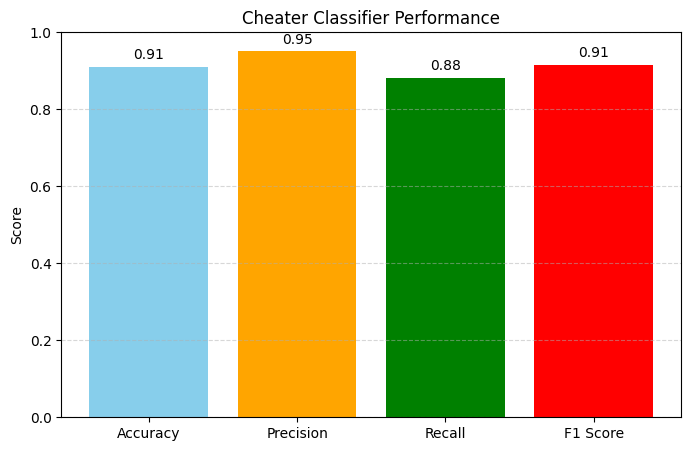

Accuracy : 0.9104545454545454
Precision: 0.9501795332136446
Recall   : 0.8820833333333333
F1 Score : 0.9148660328435609


In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Define classifier
classifier = CheaterClassifier(input_dim=X_train.shape[1])
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

# Train classifier
num_epochs = 10
classifier.train()

for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = classifier(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

# Evaluate classifier
classifier.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = classifier(X_batch)
        preds = (outputs > 0.5).int()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())


# Compute metrics

acc  = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds)
rec  = recall_score(all_labels, all_preds)
f1   = f1_score(all_labels, all_preds)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values  = [acc, prec, rec, f1]


# Plot metrics
plt.figure(figsize=(8,5))
plt.bar(metrics, values, color=['skyblue', 'orange', 'green', 'red'])
plt.ylim(0,1)
plt.ylabel("Score")
plt.title("Cheater Classifier Performance")
for i, v in enumerate(values):
    plt.text(i, v+0.02, f"{v:.2f}", ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# Print metrics
print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1 Score :", f1)